## Facial keypoints detection


In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [161]:
!pip install wget

In [2]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 5.0MB/s 


In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [104]:
import wget

file_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/3486/training.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1529677490&Signature=QECqaAWuBdOt6YS%2B4NYDpe7CUoUl2%2BHBDmUQeb4D%2B7fv%2Fl89vqEiawkoQkdAhgeQica7mCRsblVfF6RljGdXpPVZdgH4z1TLPAVa%2FvdXD5%2FafNWpmqSTxI7t9REH9Ikzja9J11g4UxqOtI48fS4iZRMWyKOJeRqTC%2FN4tcm%2B2AZD%2Fsbr5ep9OeX%2B4YcEkh24Lz60baSuRHeCovneQls53IYxGhlLDexCQYomqan8m8UfAeJMVUlIdSyesgF2ZxvHCEDVBViU2TRXFihntCUBK8TFyJD3ArnNT8qLBdIdldkELzwIma4qy95o3oeaJvnOWLWlAZbXwNTcEHupVIpkkQ%3D%3D'

file_name = wget.download(file_url)

In [162]:
import wget

file_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle/3486/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1529747290&Signature=Eu8ZPNYC4v4hWEmjsLA8VzseaG2SXM9KThftm0OfgbRaVz9CrrZXZ2WtT4EtRklIQpFFM%2B8jAlUl7%2B%2FPV6IjjFGMCXkbeDREmHGDmut1HBiZGLBgXWiucj4zvEwp13l%2BfvxkrSYMURR5eWZtNRhJ3NOtE1GQfOEYtmJlaWIc%2BcqVFOMu1bXvITLrQkMyULqeoUL%2BWbgq%2BVbl4JA5XQsGDcuIo1CupgiyfZYs0pP4mWG4kCGlHZfGeDJMBNm6CFin0289myZ8F1gDlspgg%2FdliJ1Pp8ZNQep5x8Pk6riGNZ1jGZ03Sv0zwEu4zynCWmpAHkRjtpXkjQleKcjKCo5Z7g%3D%3D'
file_name = wget.download(file_url)

In [2]:
!ls "drive/Colab Notebooks"

best_weights.h5			 imgs.npy      tutorial.ipynb
Copy of Facial keypoints.ipynb	 points.npy    utils.py
dataset				 test	       weights.h5
Facial-Keypoint-Detection.ipynb  test.csv
Facial keypoints.ipynb		 training.csv


In [163]:
!ls

datalab  my_model_final.h5  training (1).zip  weights.final_2.hdf5
drive	 test.zip	    training.zip


In [49]:
# unzip files in datalab
!unzip 'drive/Colab Notebooks/imgs.zip' -d 'drive/Colab Notebooks/'

Archive:  drive/Colab Notebooks/imgs.zip
  inflating: drive/Colab Notebooks/imgs.npy  


In [164]:
# unzip files in datalab
!unzip 'test.zip' -d 'drive/Colab Notebooks/'

Archive:  test.zip
  inflating: drive/Colab Notebooks/test.csv  


In [106]:
# unzip files in datalab
!unzip 'training.zip' -d 'drive/Colab Notebooks/'

Archive:  training.zip
  inflating: drive/Colab Notebooks/training.csv  


### Load and preprocess data

In [1]:
from skimage.io import imread
from skimage.transform import resize
import os
import cv2 
import numpy as np
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
def load_data(dirname, test=False):
    # read the csv data
    data = pd.read_csv(dirname)
    # drop the missing value rows 
    data = data.dropna()

    # convert the string pixels values into an matix
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # convert the string image data to float
    imgs = np.vstack(data['Image'].values)/255
    # reshape the matrix
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # convert to float
    imgs = imgs.astype(np.float32)
    
    if test == False:
        # extract the points 
        points = data[data.columns[:-1]].values

        # scale the points [-0.5,0.5]
        points = points/96 - 0.5
        # convert it to float
        points = points.astype(np.float32)
    
    # shuffle the data
    imgs, points = shuffle(imgs, points)
    
    return imgs, points

In [ ]:
# training data
imgs_train, points_train = load_data(dirname = 'drive/Colab Notebooks/training.csv')

In [0]:
# testing data
imgs_test, points_test = load_data(dirname = 'drive/Colab Notebooks/test.csv')

In [150]:
print('Training image data: ' + str(imgs_train.shape))
print('Training points data: ' + str(points_train.shape))

Training image data: (2140, 96, 96)
Training points data: (2140, 30)


In [151]:
print('Testing image data: ' + str(imgs_test.shape))
print('Testing points data: ' + str(points_test.shape))

Testing image data: (1783, 96, 96)
Testing points data: (1783, 1)


In [189]:
points[0][:]

array([0.68559724, 0.38600346, 0.29375   , 0.38810068, 0.6017778 ,
       0.39019445, 0.77779514, 0.38810068, 0.3901389 , 0.39438543,
       0.2078368 , 0.40276736, 0.57872915, 0.30637848, 0.8301805 ,
       0.3294271 , 0.41109374, 0.30847222, 0.14287847, 0.37552777,
       0.5116736 , 0.6060243 , 0.70445484, 0.7506111 , 0.30213195,
       0.75270486, 0.50748265, 0.7149861 , 0.5116736 , 0.90776736],
      dtype=float32)

array([ 0.19080555, -0.10878819, -0.20104167, -0.10669097,  0.10698611,
       -0.10459723,  0.28300348, -0.10669097, -0.10465278, -0.10040625,
       -0.28695485, -0.0920243 ,  0.0839375 , -0.18841319,  0.3353889 ,
       -0.16536458, -0.08369792, -0.18631944, -0.35191318, -0.11926389,
        0.01688194,  0.11123264,  0.2096632 ,  0.25581944, -0.19265972,
        0.2579132 ,  0.01269097,  0.22019444,  0.01688194,  0.4129757 ],
      dtype=float32)

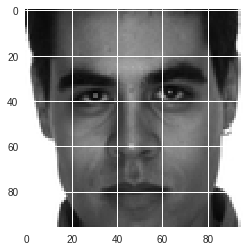

In [152]:
plt.imshow(np.squeeze(imgs_train[1]), cmap='gray')
points[0]

### Visualize data

In [0]:
def visualize_points(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

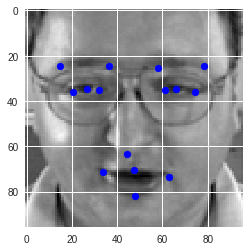

In [153]:
id = 59
visualize_points(imgs_train[id], points_train[id])

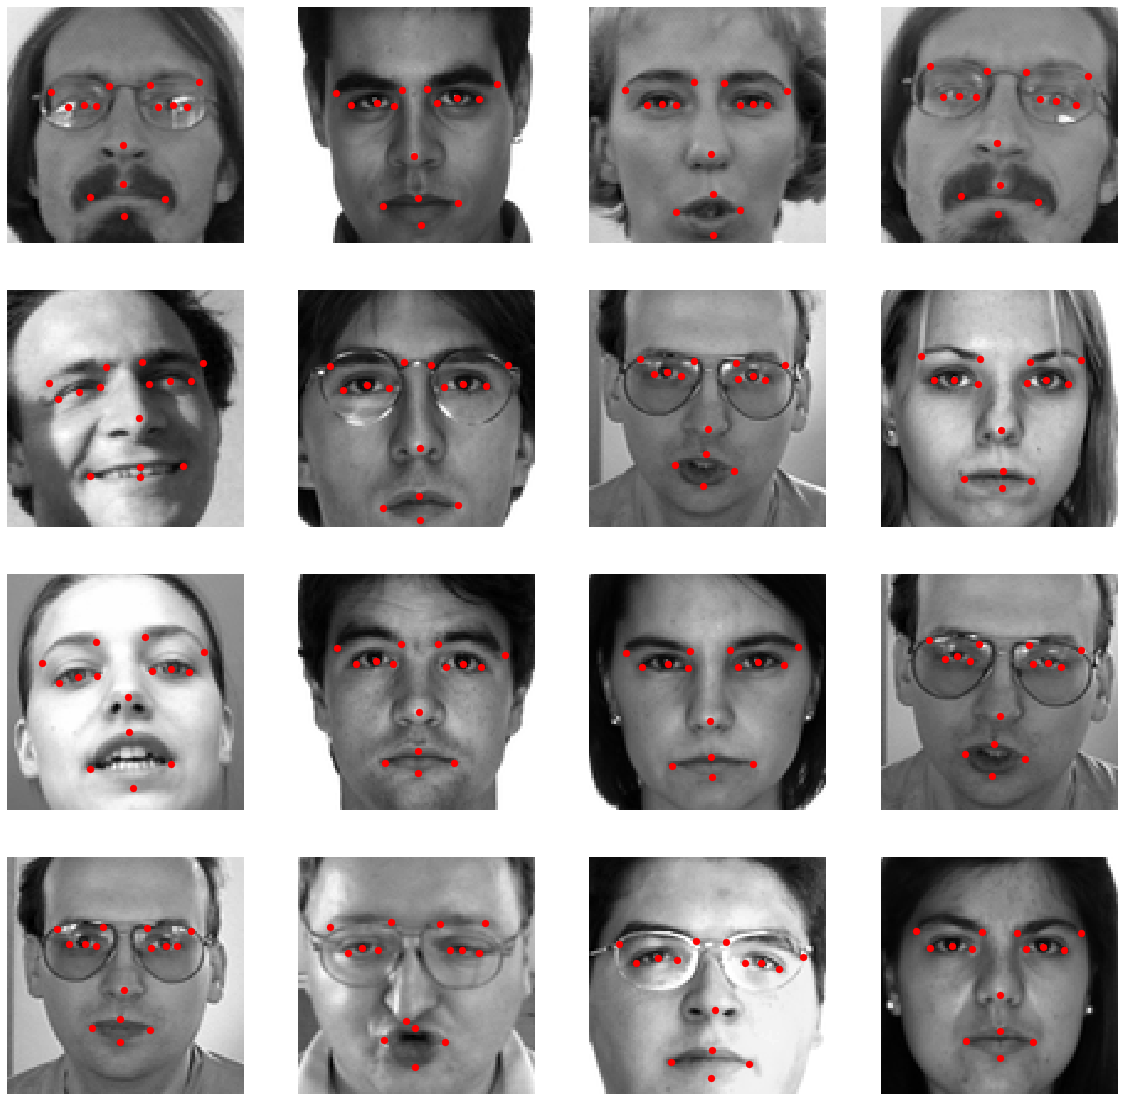

In [157]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    visualize_points(imgs_train[i], points_train[i])
plt.show()

### Simple data augmentation

In [0]:
def flip_img(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # flip the image
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # flip the points
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    return new_img, new_points
            


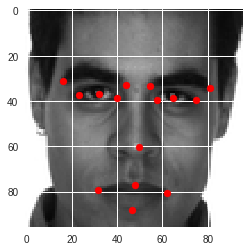

In [159]:
f_img, f_points = flip_img(imgs_train[1], points_train[1])
visualize_points(f_img, f_points)

In [128]:
# Write your code here
aug_imgs_train = []
aug_points_train = []

# apply flipping operation
for i in tqdm(range(0,imgs_train.shape[0])):
    aug_img, aug_point = flip_img(imgs_train[i], points_train[i])
     # original data
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # augmented data
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

100%|██████████| 2033/2033 [00:12<00:00, 161.45it/s]

(4066, 96, 96)
(4066, 30)


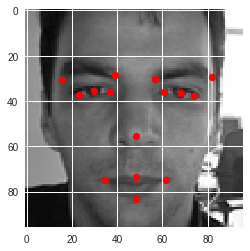

In [160]:
id = 28
visualize_points(imgs_train[id], points_train[id])

In [ ]:
visualize_points(aug_imgs_train[id], aug_points_train[id])

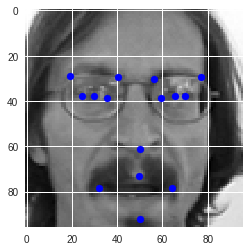

In [131]:
visualize_points(aug_imgs_train[id+1], aug_points_train[id+1])

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import SGD, Adam

In [145]:
# reshape the images
aug_imgs_train = aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1)
imgs_val = imgs_val.reshape(imgs_val.shape[0], 96, 96, 1)

In [0]:
model.load_weights('drive/Colab Notebooks/best_weights.h5')

In [174]:
checkpoint = ModelCheckpoint('drive/Colab Notebooks/best_weights.h5', verbose=1, save_best_only=True)
hist = History()

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 8, 8, 128)         73856     
__________

In [180]:
hist = model.fit(imgs.reshape(imgs.shape[0], 96, 96, 1), points, validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
          shuffle=True, epochs=150, verbose=1)
model.save_weights('drive/Colab Notebooks/weights.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 1s 569us/step - loss: 4.2055e-04 - acc: 0.7792 - val_loss: 6.0044e-04 - val_acc: 0.7453

Epoch 00001: val_loss improved from 0.00060 to 0.00060, saving model to drive/Colab Notebooks/best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 529us/step - loss: 4.1276e-04 - acc: 0.7704 - val_loss: 6.1212e-04 - val_acc: 0.7570

Epoch 00002: val_loss did not improve from 0.00060
Epoch 3/150
1712/1712 [==============================] - 1s 498us/step - loss: 4.1872e-04 - acc: 0.7856 - val_loss: 6.1897e-04 - val_acc: 0.7453

Epoch 00003: val_loss did not improve from 0.00060
Epoch 4/150
1712/1712 [==============================] - 1s 532us/step - loss: 4.1250e-04 - acc: 0.7716 - val_loss: 6.0914e-04 - val_acc: 0.7523

Epoch 00004: val_loss did not improve from 0.00060
Epoch 5/150
1712/1712 [==============================] - 1s 532us/step - loss: 4.0722e-04 - acc: 0.7728 - 

  64/1712 [>.............................] - ETA: 0s - loss: 3.1297e-04 - acc: 0.79691712/1712 [==============================] - 1s 524us/step - loss: 3.3120e-04 - acc: 0.7944 - val_loss: 5.8859e-04 - val_acc: 0.7477

Epoch 00040: val_loss did not improve from 0.00058
Epoch 41/150
1712/1712 [==============================] - 1s 531us/step - loss: 3.3154e-04 - acc: 0.7810 - val_loss: 6.0050e-04 - val_acc: 0.7430

Epoch 00041: val_loss did not improve from 0.00058
Epoch 42/150
1712/1712 [==============================] - 1s 526us/step - loss: 3.3096e-04 - acc: 0.7909 - val_loss: 5.7891e-04 - val_acc: 0.7547

Epoch 00042: val_loss improved from 0.00058 to 0.00058, saving model to drive/Colab Notebooks/best_weights.h5
Epoch 43/150
1712/1712 [==============================] - 1s 549us/step - loss: 3.2793e-04 - acc: 0.7961 - val_loss: 6.1247e-04 - val_acc: 0.7220

Epoch 00043: val_loss did not improve from 0.00058
Epoch 44/150
1712/1712 [==============================] - 1s 528us/step - los

 320/1712 [====>.........................] - ETA: 0s - loss: 2.7056e-04 - acc: 0.82191712/1712 [==============================] - 1s 540us/step - loss: 2.7940e-04 - acc: 0.8078 - val_loss: 5.7046e-04 - val_acc: 0.7313

Epoch 00084: val_loss did not improve from 0.00056
Epoch 85/150
1712/1712 [==============================] - 1s 520us/step - loss: 2.7031e-04 - acc: 0.8067 - val_loss: 5.6953e-04 - val_acc: 0.7453

Epoch 00085: val_loss did not improve from 0.00056
Epoch 86/150
1712/1712 [==============================] - 1s 534us/step - loss: 2.5893e-04 - acc: 0.8043 - val_loss: 5.7063e-04 - val_acc: 0.7500

Epoch 00086: val_loss did not improve from 0.00056
Epoch 87/150
1712/1712 [==============================] - 1s 530us/step - loss: 2.5439e-04 - acc: 0.8037 - val_loss: 5.5957e-04 - val_acc: 0.7617

Epoch 00087: val_loss improved from 0.00056 to 0.00056, saving model to drive/Colab Notebooks/best_weights.h5
Epoch 88/150
1712/1712 [==============================] - 1s 561us/step - los

  64/1712 [>.............................] - ETA: 0s - loss: 2.4630e-04 - acc: 0.76561712/1712 [==============================] - 1s 535us/step - loss: 2.2480e-04 - acc: 0.8172 - val_loss: 5.5685e-04 - val_acc: 0.7547

Epoch 00129: val_loss did not improve from 0.00054
Epoch 130/150
1712/1712 [==============================] - 1s 525us/step - loss: 2.1961e-04 - acc: 0.8289 - val_loss: 5.4759e-04 - val_acc: 0.7523

Epoch 00130: val_loss did not improve from 0.00054
Epoch 131/150
1712/1712 [==============================] - 1s 531us/step - loss: 2.1917e-04 - acc: 0.8084 - val_loss: 5.6663e-04 - val_acc: 0.7617

Epoch 00131: val_loss did not improve from 0.00054
Epoch 132/150
1712/1712 [==============================] - 1s 528us/step - loss: 2.1735e-04 - acc: 0.8172 - val_loss: 5.4458e-04 - val_acc: 0.7477

Epoch 00132: val_loss did not improve from 0.00054
Epoch 133/150
1712/1712 [==============================] - 1s 523us/step - loss: 2.2108e-04 - acc: 0.8283 - val_loss: 5.4792e-04 - va

In [0]:
model.save('drive/Colab Notebooks/model.h5')

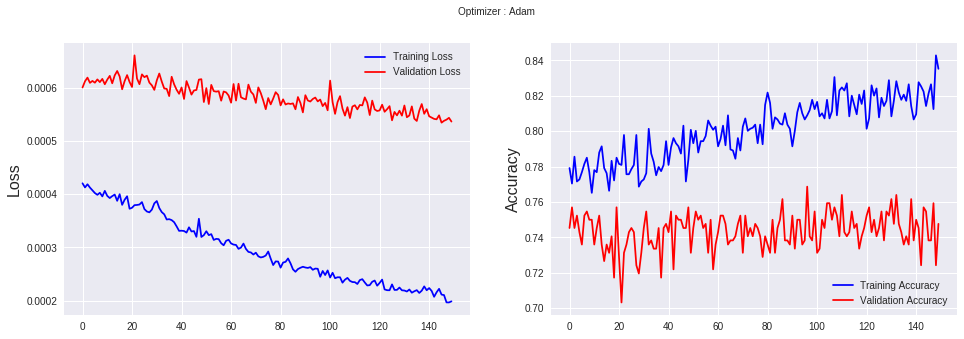

In [181]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()



### Visualize results

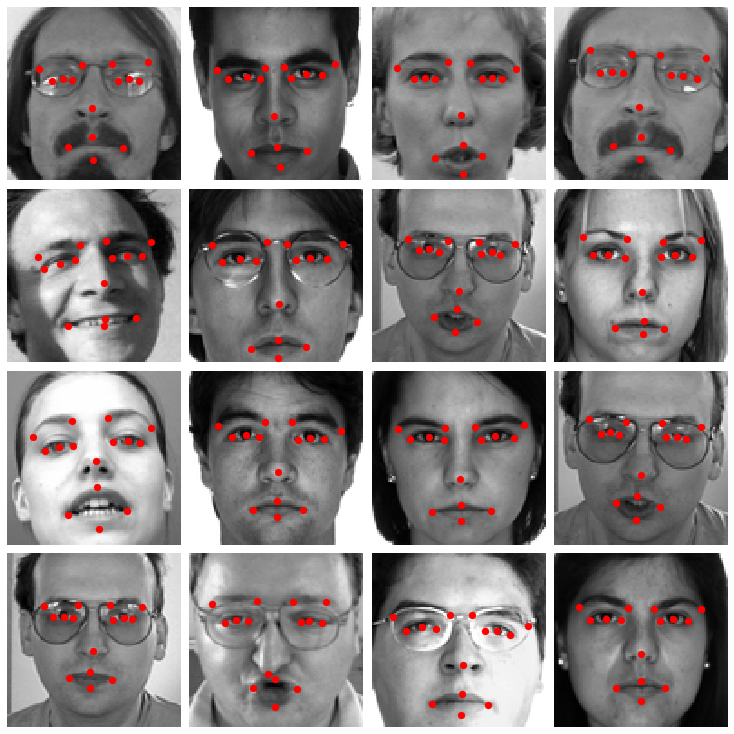

In [185]:
y_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    visualize_points(imgs_train[i], points_train[i])

In [ ]:
for i in range(1,2):
    img = cv2.imread('drive/Colab Notebooks/test/'+str(i)+'.jpg',0)
    img = cv2.resize(img, (96,96))
    new_img = img.reshape(1,96,96,1)
    pts = model.predict(new_img)[0]
    print(pts.shape)
    visualize_points(img, pts)